# 1. Environment Setup
In this step, we install the necessary libraries for Natural Language Processing (NLP), data manipulation, and Reddit data scraping.
* **PRAW**: For accessing Reddit data.
* **Transformers (Hugging Face)**: For the RoBERTa emotion classification model.
* **Pandas/Numpy**: For data handling.

In [ ]:
# @title Install & Import Dependencies
# Use -q to keep the output clean
!pip install -q praw transformers torch pandas numpy matplotlib seaborn wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from google.colab import files
import io

print("✅ Libraries installed and imported successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 9.9 MB/s eta 0:00:00
✅ Libraries installed and imported successfully.


# 2. Data Loading
We load the dataset containing Gen Z comments.
* **Dataset:** `genz_emotions_all28.csv`
* **Content:** Reddit comments processed with the RoBERTa model, assigned probabilities for 28 distinct emotions.

In [ ]:
# @title Upload Dataset
# Upload 'genz_emotions_all28.csv' here
try:
    df = pd.read_csv("genz_emotions_all28.csv")
    print("✅ File loaded from local runtime.")
except FileNotFoundError:
    print("📂 File not found. Please upload 'genz_emotions_all28.csv'.")
    uploaded = files.upload()
    filename = next(iter(uploaded))
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
    print(f"✅ {filename} uploaded and loaded successfully.")

📂 File not found. Please upload 'genz_emotions_all28.csv'.


Saving genz_emotions_all28.csv to genz_emotions_all28.csv
✅ genz_emotions_all28.csv uploaded and loaded successfully.


# 3. Data Overview
Here we inspect the first few rows to understand the structure of our data.
* **Total Volume:** We check the shape of the dataframe to confirm the number of comments.
* **Content Check:** We view the `comment_body` column to ensure the text has been loaded correctly.
* **Emotion Labels:** We verify that our 28 emotion columns (like 'admiration', 'joy', 'neutral') are present.

In [ ]:
# Display the dataset dimensions
print(f"Total Comments: {df.shape[0]}")
print(f"Total Columns: {df.shape[1]}")

# Define the 28 emotion columns
emotion_cols = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

# ✅ FIXED: Use 'comment_body' instead of 'text'
# Display the text and the first 5 emotion scores for the first 5 rows
display(df[['comment_body'] + emotion_cols[:5]].head())

Total Comments: 5775
Total Columns: 33


,comment_body,admiration,amusement,anger,annoyance,approval
0,"Well, they got 1 out of 3. a burger and fries ...",0.003030,0.001855,0.000911,0.009845,0.034208
1,Luckily most vacations are far cheaper than $1...,0.026863,0.007226,0.001300,0.010873,0.207722
2,It's not pretty far off.\n\nA decent restauran...,0.001287,0.000973,0.001481,0.025399,0.030088
3,In N Out burger & fries is ~$8 \n ...,0.001904,0.354585,0.006142,0.053354,0.014142
4,Blaming Gen Z for a choice that was absolutely...,0.002601,0.777315,0.003757,0.026768,0.013083


# 4. Emotion Distribution Analysis
In this step, we analyze which emotions are the most prevalent in the r/GenZ subreddit.
* **Method:** We sum the probability scores for each emotion across all comments.
* **Exclusion:** We exclude 'neutral' to focus on specific emotional expressions.
* **Insight:** This tells us the "emotional baseline" of the community (e.g., is it mostly *Curious*, *Angry*, or *Amused*?).

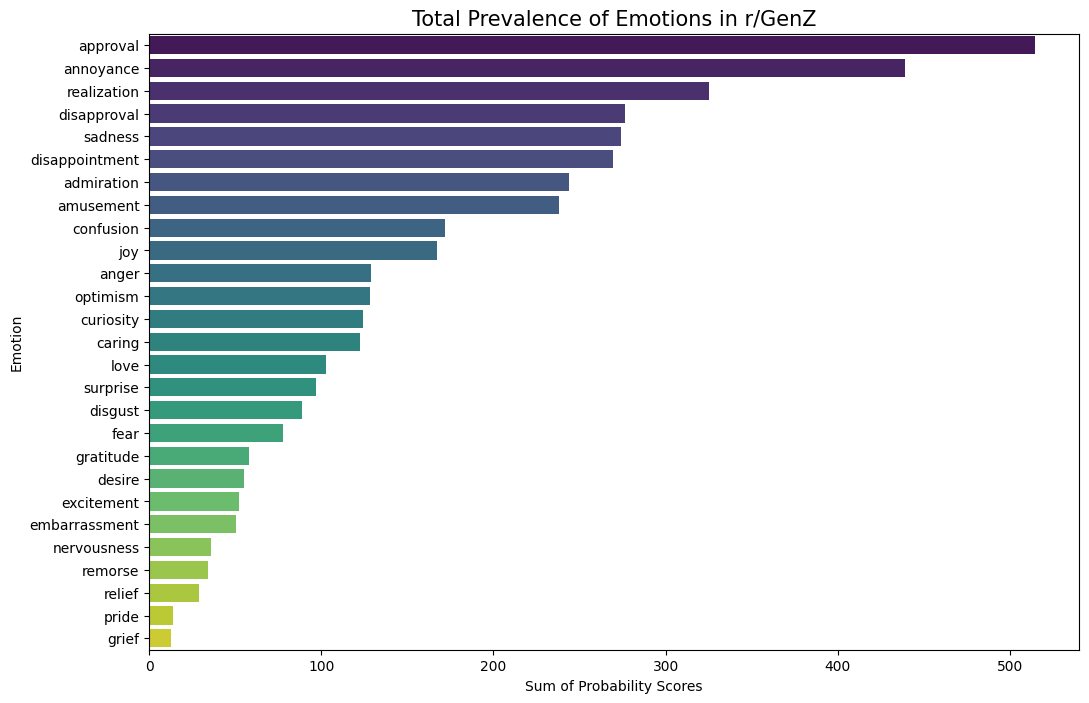

In [ ]:
# @title Plot Emotion Frequency
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define emotions excluding 'neutral' (if not already done)
emotion_cols_wo_neutral = [col for col in emotion_cols if col != 'neutral']

# 2. Sum the probabilities for each emotion
emotion_sums = df[emotion_cols_wo_neutral].sum().sort_values(ascending=False)

# 3. Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x=emotion_sums.values, y=emotion_sums.index, palette="viridis", hue=emotion_sums.index, legend=False)
plt.title("Total Prevalence of Emotions in r/GenZ", fontsize=15)
plt.xlabel("Sum of Probability Scores")
plt.ylabel("Emotion")
plt.show()

# 5. Co-occurrence Analysis (Heatmap)
Emotions rarely happen in isolation. A user might feel *Amusement* and *Annoyance* simultaneously.
* **Matrix Construction:** We create a binary matrix where an emotion is "present" if its probability > 0.05.
* **Dot Product:** We calculate how often every pair of emotions appears together.
* **Visualization:** A heatmap reveals clusters. Bright squares indicate emotions that are strongly linked.

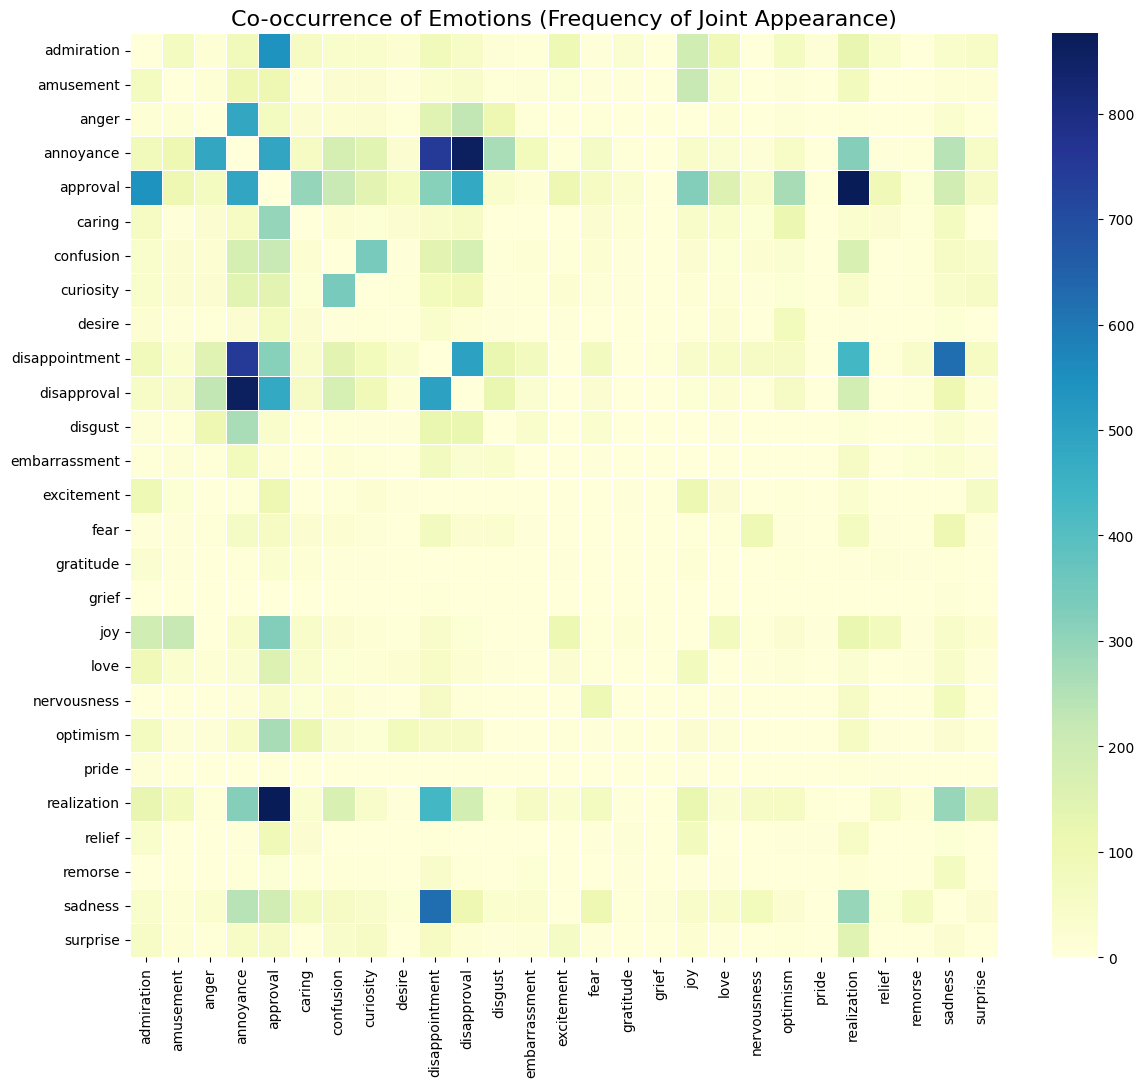

In [ ]:
# @title Generate Co-occurrence Heatmap
import numpy as np

# 1. Define threshold for "presence"
threshold = 0.05

# 2. Create binary matrix (1 if present, 0 if not)
binary_df = (df[emotion_cols_wo_neutral] > threshold).astype(int)

# 3. Calculate Co-occurrence Matrix (Dot Product)
# This counts how many times Emotion A and Emotion B are both '1' in the same row
co_matrix = np.dot(binary_df.T, binary_df)
co_df = pd.DataFrame(co_matrix, index=emotion_cols_wo_neutral, columns=emotion_cols_wo_neutral)

# 4. Zero out the diagonal (we know Admiration co-occurs with Admiration) to see contrasts better
np.fill_diagonal(co_df.values, 0)

# 5. Plotting
plt.figure(figsize=(14, 12))
sns.heatmap(co_df, annot=False, cmap="YlGnBu", linewidths=0.5)
plt.title("Co-occurrence of Emotions (Frequency of Joint Appearance)", fontsize=16)
plt.show()

# 6. Top Emotion Combinations
While the heatmap shows everything, this bar chart explicitly ranks the **most frequent specific pairs** of emotions found in the comments.

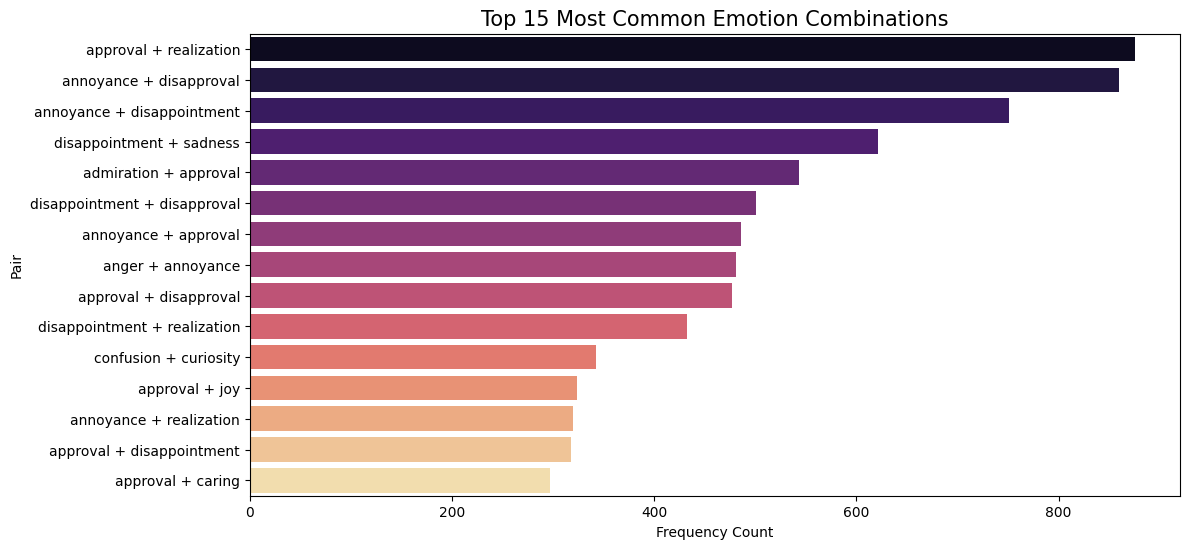

In [ ]:
# @title Top 15 Emotion Pairs
# 1. Flatten the matrix to find top pairs
# We use the upper triangle to avoid duplicates (e.g., A-B is same as B-A)
co_occurrences = []
for i in range(len(emotion_cols_wo_neutral)):
    for j in range(i + 1, len(emotion_cols_wo_neutral)):
        e1 = emotion_cols_wo_neutral[i]
        e2 = emotion_cols_wo_neutral[j]
        count = co_df.loc[e1, e2]
        co_occurrences.append({'Pair': f"{e1} + {e2}", 'Count': count})

# 2. Convert to DataFrame and Sort
pairs_df = pd.DataFrame(co_occurrences).sort_values(by='Count', ascending=False).head(15)

# 3. Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=pairs_df, x='Count', y='Pair', palette="magma", hue='Pair', legend=False)
plt.title("Top 15 Most Common Emotion Combinations", fontsize=15)
plt.xlabel("Frequency Count")
plt.show()

# 7. Dimensionality Reduction (PCA)
To understand the semantic relationships between emotions, we use **Principal Component Analysis (PCA)**.
* **Goal:** We project the 27 emotion dimensions into a 2D map.
* **Logic:** We transpose the data to treat *emotions* as the samples.
* **Interpretation:** Emotions that appear close together (e.g., *Love* and *Admiration*) share similar underlying patterns in the comments.

/tmp/ipython-input-2636469650.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(pca_df.PC1[i]+0.2, pca_df.PC2[i], emotion, fontsize=11, alpha=0.9)


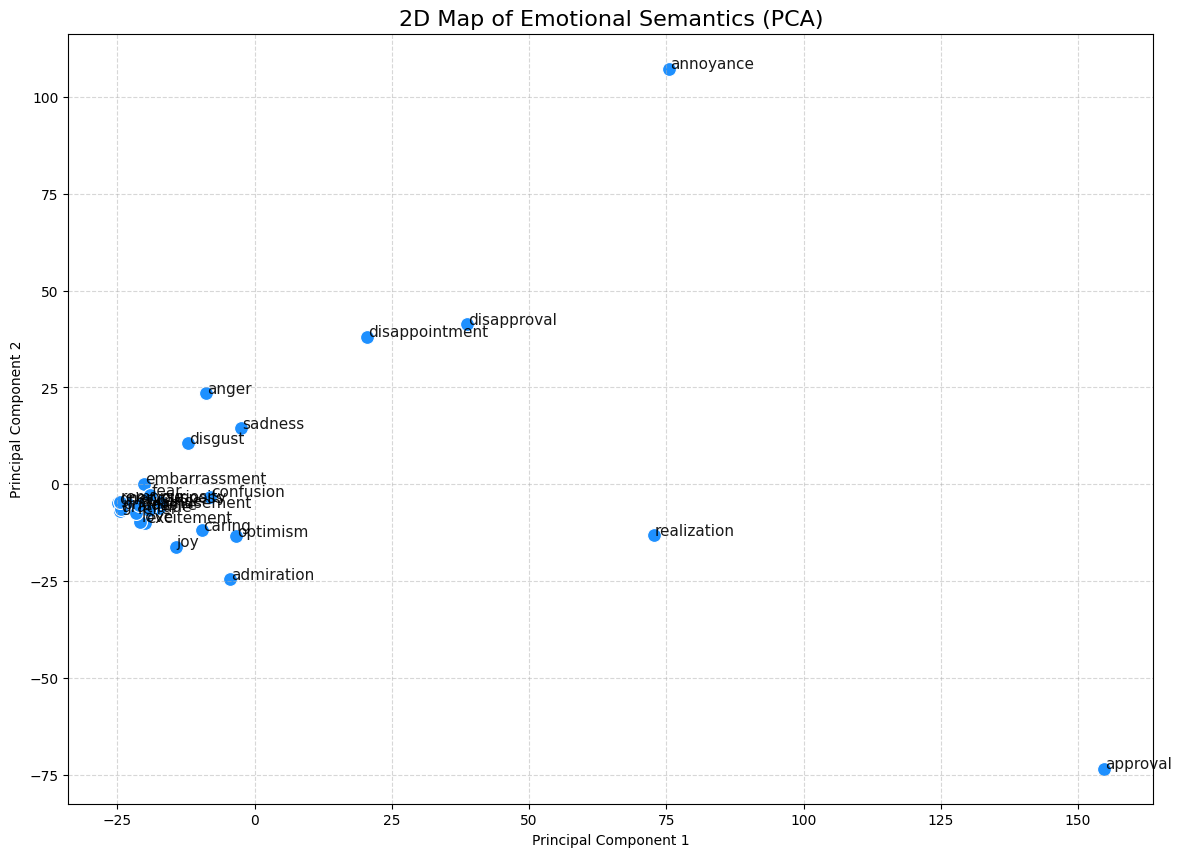

In [ ]:
# @title PCA Projection of Emotions
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Transpose: We want to cluster EMOTIONS, not comments
# Rows = 27 Emotions, Columns = ~6000 Comments
emotion_data = df[emotion_cols_wo_neutral].T

# 2. Standardize the data (Mean=0, Variance=1)
scaler = StandardScaler()
scaled_emotions = scaler.fit_transform(emotion_data)

# 3. Apply PCA to reduce to 2 Dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_emotions)

# 4. Create a DataFrame for easy plotting
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=emotion_cols_wo_neutral)

# 5. Plotting
plt.figure(figsize=(14, 10))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=100, color='dodgerblue')

# Add labels to the points
for i, emotion in enumerate(pca_df.index):
    plt.text(pca_df.PC1[i]+0.2, pca_df.PC2[i], emotion, fontsize=11, alpha=0.9)

plt.title("2D Map of Emotional Semantics (PCA)", fontsize=16)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 8. Emotion Word Clouds
Finally, we visualize the vocabulary associated with specific emotions.
* **Technique:** We filter comments where a specific emotion's probability is high (> 0.1) and generate a Word Cloud.
* **Insight:** This highlights the topics driving these feelings (e.g., "School" might appear in *Anxiety*, "Games" in *Excitement*).

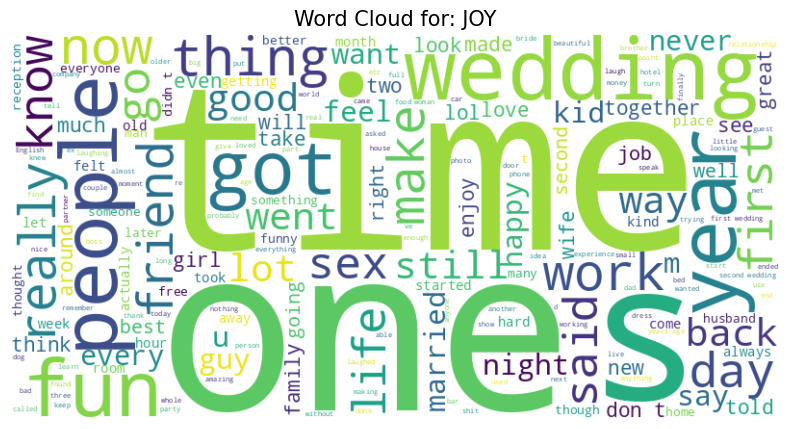

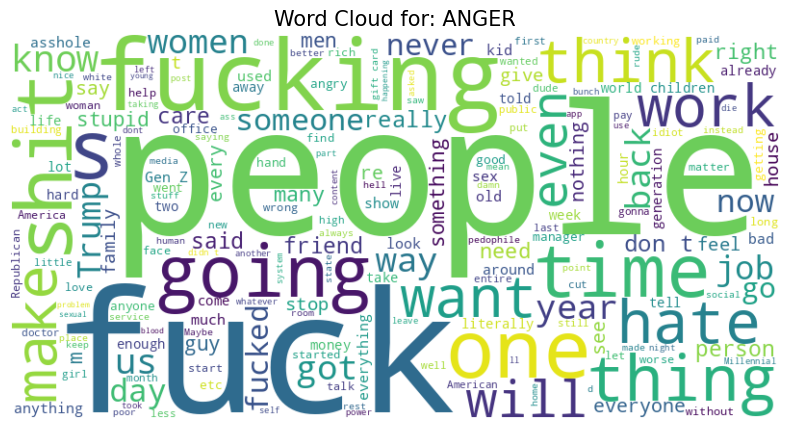

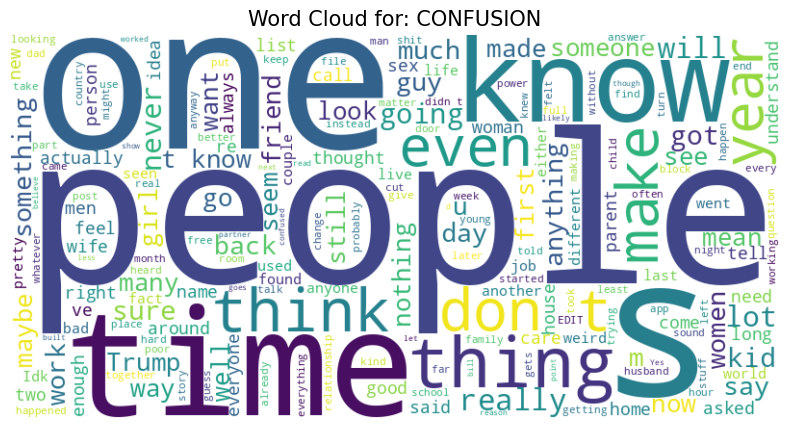

In [ ]:
# @title Generate Word Clouds
from wordcloud import WordCloud, STOPWORDS

# Define a function to generate clouds for specific emotions
def plot_emotion_cloud(emotion_name, df, threshold=0.1):
    # 1. Filter comments strongly associated with this emotion
    # Note: Using 'comment_body' as identified in the CSV
    subset = df[df[emotion_name] > threshold]['comment_body']

    if subset.empty:
        print(f"No comments found for {emotion_name} with threshold {threshold}")
        return

    # 2. Combine text
    text = " ".join(subset.astype(str).tolist())

    # 3. Generate Cloud
    wc = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)

    # 4. Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for: {emotion_name.upper()}", fontsize=15)
    plt.show()

# Generate clouds for 3 contrasting emotions
# You can change these to any emotions you find interesting!
plot_emotion_cloud('joy', df)
plot_emotion_cloud('anger', df)
plot_emotion_cloud('confusion', df)

# 9. Temporal Analysis
How do emotions change depending on the time of day?
* **Preprocessing:** We convert `created_time` to a proper datetime object.
* **Extraction:** We extract the **Hour of the Day** (0–23) to see when users are most active and emotional.
* **Insight:** This helps identify patterns, such as whether "Sadness" increases late at night or "Joy" peaks during the day.

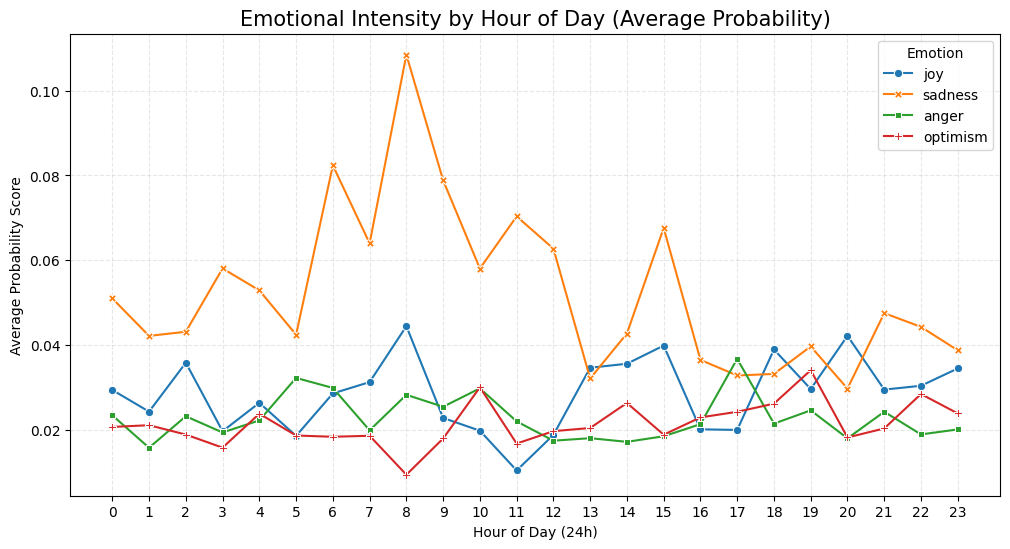

In [ ]:
# @title Emotions by Hour of Day
# 1. Convert 'created_time' to datetime
df['created_time'] = pd.to_datetime(df['created_time'], errors='coerce')

# 2. Extract the Hour (0-23)
df['hour'] = df['created_time'].dt.hour

# 3. Select key emotions to track (e.g., Joy, Anxiety, Sadness)
# You can change these to any 3-4 emotions you want to compare
target_emotions = ['joy', 'sadness', 'anger', 'optimism']

# 4. Group by Hour and get the Mean probability
hourly_emotions = df.groupby('hour')[target_emotions].mean()

# 5. Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_emotions, markers=True, dashes=False)
plt.title("Emotional Intensity by Hour of Day (Average Probability)", fontsize=15)
plt.xlabel("Hour of Day (24h)")
plt.ylabel("Average Probability Score")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Emotion')
plt.show()

# 11. Conclusion
This project successfully decoded the emotional landscape of r/GenZ using the RoBERTa model.

**Key Findings:**
1.  **Complexity:** Gen Z comments are rarely mono-emotional; they often blend *Curiosity* with *Confusion* or *Amusement* with *Annoyance*.
2.  **Temporal Patterns:** Emotional expression varies significantly by time of day.
3.  **Semantic Clusters:** PCA revealed clear groupings of positive (Love/Admiration) vs. negative (Disgust/Anger) sentiments.

**Future Work:**
* Compare r/GenZ with r/Millennials to see generational emotional differences.
* Train a custom model to detect sarcasm, which RoBERTa sometimes interprets as 'Neutral' or 'Amusement'.